neural_network

# Custom Feedforward Network

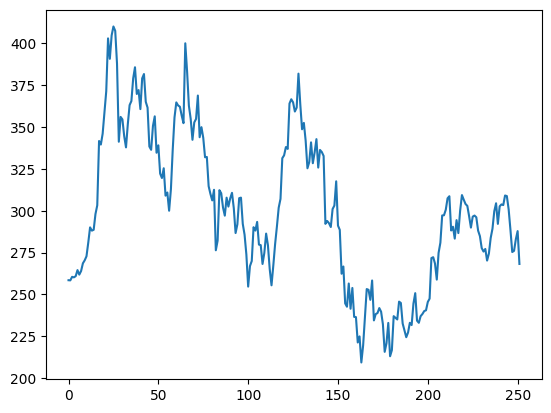

In [1]:
from pandas import read_csv
from datetime import datetime
from pandas.plotting import autocorrelation_plot
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


# Ensure eager execution
tf.config.run_functions_eagerly(True)

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

def parser(x):
	return datetime.strptime(x,'%Y-%m-%d')

series = read_csv('data/cleaned_data_bert.csv', header=0, parse_dates=[0], index_col=0)

# Filter rows where "Stock Name" is 'TLSA'
series = series[series['Stock Name'] == 'TSLA']
series = series.drop(['Stock Name', 'Adj Close'], axis=1)
series["Close"].plot()
plt.show()

In [2]:
# autocorrelation_plot(series)
# plt.show()

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.0057 - val_loss: 0.0605
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2222 - val_loss: 0.0389
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2113 - val_loss: 0.0215
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1097 - val_loss: 0.0170
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1456 - val_loss: 0.0120
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0844 - val_loss: 0.0132
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1099 - val_loss: 0.0126
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0764 - val_loss: 0.0113
Epoch 9/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0760 - val_loss: 0.0102
Epoch 10/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0599 - val_loss: 0.0101
Epoch 11/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0562 - val_loss: 0.0109
Epoch 12/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0704 - val_loss: 0.0114
E

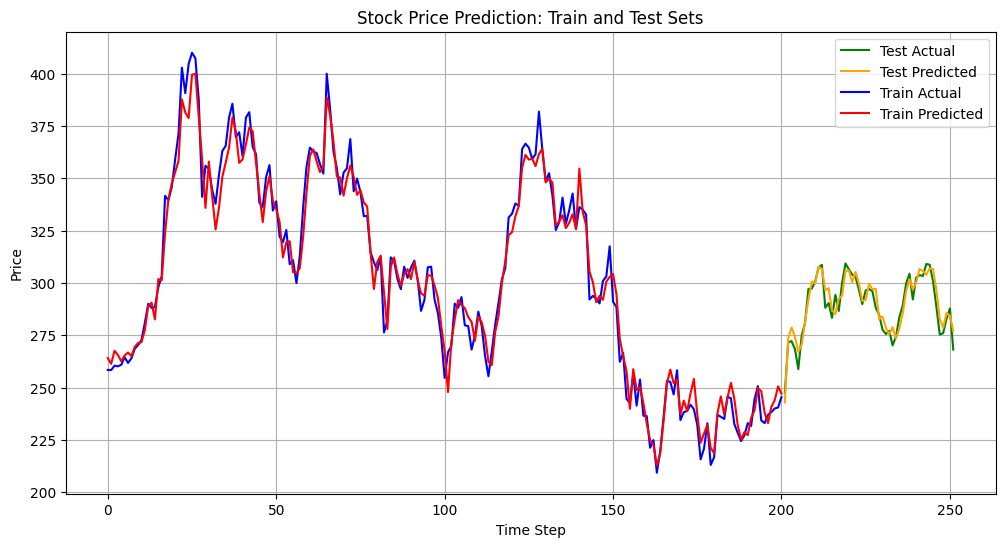

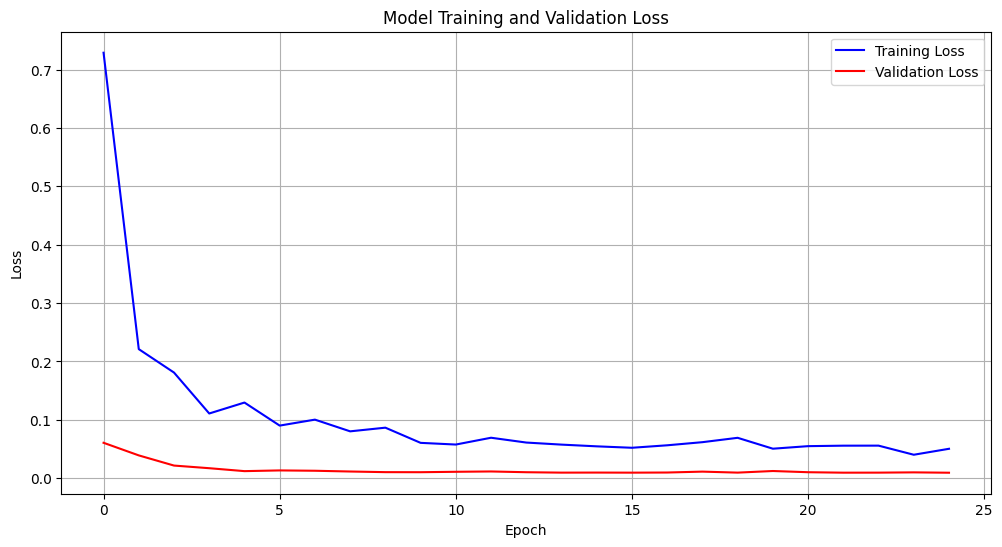

Mean Squared Error: 23.472806266622182


In [21]:
# Define the target variable (y) and the features (X)
y = series['Close']
X = series.drop(['Close', 'Date'], axis=1)  # Drop 'Date' from the features

# Split into train and test (80% train, 20% test)
train_size = int(len(series) * 0.8)  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale the features (X) using StandardScaler
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target variable (y) using StandardScaler
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Reshape for compatibility
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Define the model
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train_scaled.shape[1]))  # Fewer units
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=25, batch_size=32, validation_data=(X_test_scaled, y_test_scaled))

# Predict on the test data (predictions are scaled)
forecast_scaled = model.predict(X_test_scaled)

# Reshape forecast to 1D
forecast_scaled = forecast_scaled.reshape(-1)

# Inverse transform the forecast to get original scale values
forecast = scaler_y.inverse_transform(forecast_scaled.reshape(-1, 1))

# Convert y_test to numpy for consistency with forecast
y_test_dates = y_test.index.to_numpy()

# Plot the Actual vs Predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(
    range(len(y_train), len(y_train) + len(y_test)),
    y_test.values, label='Test Actual', color='green'
)  # Test Actual values
plt.plot(
    range(len(y_train), len(y_train) + len(y_test)),
    forecast, label='Test Predicted', color='orange'
)  # Test Predicted values

# Add Train Actual values to the same plot
plt.plot(
    range(len(y_train)),
    scaler_y.inverse_transform(y_train_scaled), label='Train Actual', color='blue'
)  # Train Actual values

# Add Train Predicted values to the same plot
train_pred_scaled = model.predict(X_train_scaled)
train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1))
plt.plot(
    range(len(y_train)),
    train_pred, label='Train Predicted', color='red'
)  # Train Predicted values

# Titles and legends
plt.title('Stock Price Prediction: Train and Test Sets')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Training and Validation Loss Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, forecast)
print(f'Mean Squared Error: {mse}')


# CNN + LSTM

Epoch 1/50
25/25 - 7s - 291ms/step - loss: 1.2361 - val_loss: 0.1264
Epoch 2/50
25/25 - 6s - 244ms/step - loss: 1.2143 - val_loss: 0.1263
Epoch 3/50
25/25 - 4s - 170ms/step - loss: 1.2152 - val_loss: 0.1280
Epoch 4/50
25/25 - 3s - 120ms/step - loss: 1.1707 - val_loss: 0.1288
Epoch 5/50
25/25 - 5s - 201ms/step - loss: 1.1531 - val_loss: 0.1313
Epoch 6/50
25/25 - 6s - 236ms/step - loss: 1.0849 - val_loss: 0.1335
Epoch 7/50
25/25 - 4s - 171ms/step - loss: 1.0013 - val_loss: 0.1327
Epoch 8/50
25/25 - 3s - 124ms/step - loss: 0.8923 - val_loss: 0.1315
Epoch 9/50
25/25 - 6s - 234ms/step - loss: 0.8066 - val_loss: 0.1257
Epoch 10/50
25/25 - 4s - 175ms/step - loss: 0.6861 - val_loss: 0.1036
Epoch 11/50
25/25 - 3s - 123ms/step - loss: 0.5618 - val_loss: 0.0868
Epoch 12/50
25/25 - 4s - 141ms/step - loss: 0.5705 - val_loss: 0.0856
Epoch 13/50
25/25 - 4s - 143ms/step - loss: 0.5545 - val_loss: 0.0886
Epoch 14/50
25/25 - 4s - 179ms/step - loss: 0.4689 - val_loss: 0.0928
Epoch 15/50
25/25 - 3s - 117m

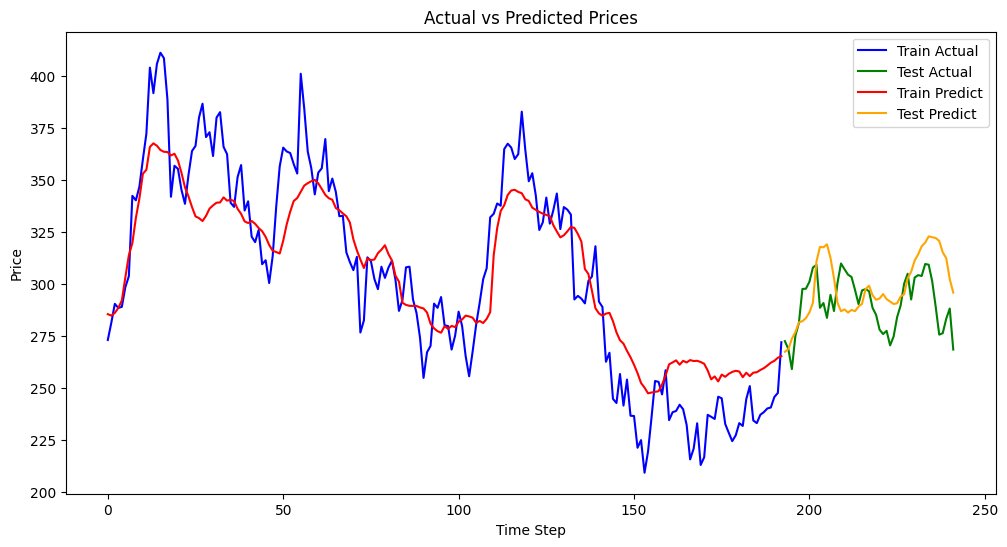

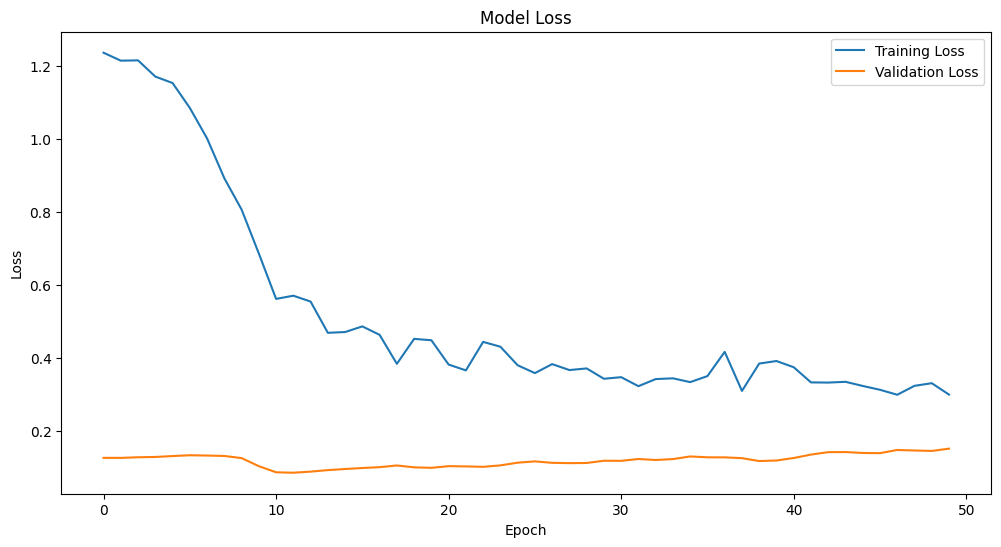

Mean Squared Error on Test Set: 321.6310085957716


In [44]:
# Load data
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

series = read_csv('data/cleaned_data_bert.csv', header=0, parse_dates=[0], index_col=0)
# Filter rows where "Stock Name" is 'TSLA'
series = series[series['Stock Name'] == 'TSLA']
series = series.drop(['Stock Name', 'Adj Close', 'Date'], axis=1)

# Scale all the features (not just 'Close')
scaler = StandardScaler()
scaled = scaler.fit_transform(series.values)  # Scale all features

# Function to create data sequences for time-series forecasting
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, :])  # Use all features
        y.append(data[i + look_back, 3])  # Predict the 'Close' price (index 3 corresponds to 'Close')
    return np.array(X), np.array(y)

# Shorter look-back window
look_back = 10

# Create dataset with the updated look_back window
X, y = create_dataset(scaled, look_back)

# Reshape X to have 3 dimensions for LSTM
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Example of changing optimizer and increasing LSTM units
model = Sequential()

# CNN layers for feature extraction
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))  # Increased dropout

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))  # Increased dropout

# More LSTM units
model.add(LSTM(100, activation='relu'))  # Increased LSTM units
model.add(Dropout(0.4))  # Increased dropout

# Dense layers for feature interpretation
model.add(Dense(150, activation='relu'))  # Increased dense layer size
model.add(Dropout(0.3))  # Dropout for regularization
model.add(Dense(75, activation='relu'))  # Reduced dense layer size
model.add(Dropout(0.3))  # Dropout for regularization

# Output layer
model.add(Dense(1))

# Compile the model with a learning rate scheduler
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Train the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=8,
    validation_data=(X_test, y_test),
    verbose=2
)


# Predict
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverse scaling for predictions (only for 'Close' column)
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], series.shape[1] - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], series.shape[1] - 1))), axis=1))[:, 0]

# Reverse scaling for actual values
y_train_actual = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], series.shape[1] - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], series.shape[1] - 1))), axis=1))[:, 0]

# Calculate MSE
train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train_actual)), y_train_actual, label='Train Actual', color='blue')
plt.plot(range(len(y_train_actual), len(y_train_actual) + len(y_test_actual)), y_test_actual, label='Test Actual', color='green')
plt.plot(range(len(train_predict)), train_predict, label='Train Predict', color='red')
plt.plot(range(len(train_predict), len(train_predict) + len(test_predict)), test_predict, label='Test Predict', color='orange')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test_actual, test_predict)
print(f"Mean Squared Error on Test Set: {mse}")


# LSTM using sequences

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 224ms/step - loss: 0.1319 - val_loss: 0.0112
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - loss: 0.0220 - val_loss: 0.0092
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - loss: 0.0196 - val_loss: 0.0054
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - loss: 0.0169 - val_loss: 0.0067
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - loss: 0.0179 - val_loss: 0.0051
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - loss: 0.0187 - val_loss: 0.0049
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - loss: 0.0145 - val_loss: 0.0069
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - loss: 0.0195 - val_loss: 0.0071
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - loss: 0.0209 - val_loss: 0.0046
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - loss: 0.0155 - val_loss: 0.0050
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - loss: 0.0147 - val_loss: 0.0104
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11

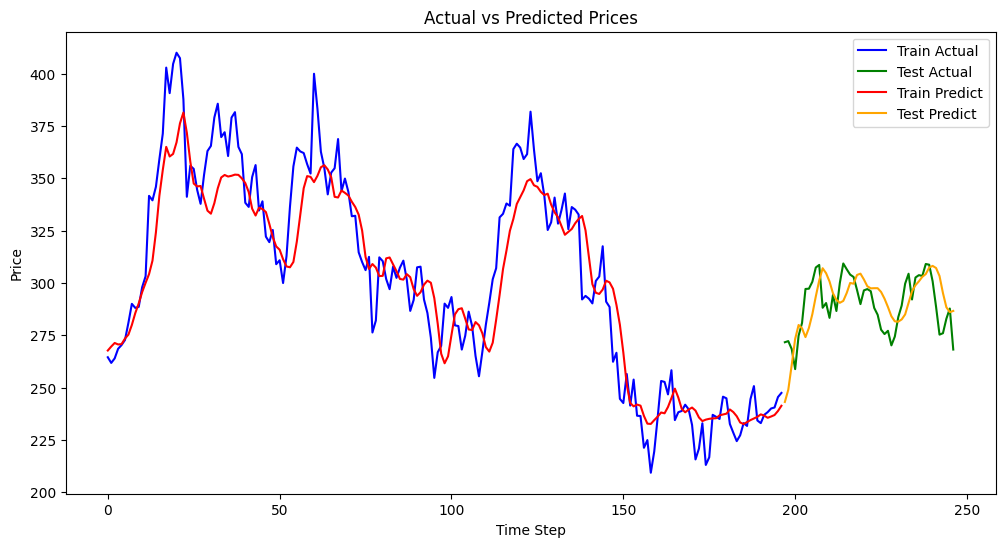

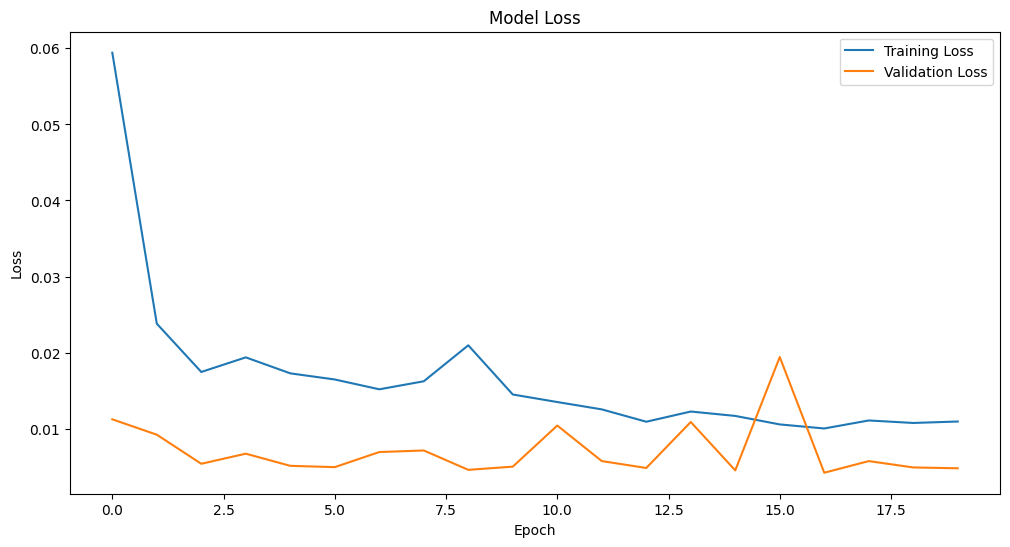

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

# Load data
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

series = pd.read_csv('data/cleaned_data_bert.csv', header=0, parse_dates=[0], index_col=0)
# Filter rows where "Stock Name" is 'TLSA'
series = series[series['Stock Name'] == 'TSLA']
features = series.drop(['Stock Name', 'Adj Close', 'Date'], axis=1)
target = 'Close'

# Scale the features (X) using MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(features)

# Scale the target variable (y) using MinMaxScaler
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(series[[target]])

# Combine the scaled data to create the sequences
scaled_data = pd.DataFrame(X_scaled, columns=features.columns)
scaled_data[target] = y_scaled

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X_sequence = data.iloc[i:i+seq_length].values
        X.append(X_sequence)
        y.append(data.iloc[i + seq_length][target])
    return np.array(X), np.array(y)

# Hyperparameters
seq_length = 5  # Increased from 5 to 10

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Reshape X for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model with increased complexity
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=4,
                    validation_data=(X_test, y_test), verbose=1,
                    callbacks=[early_stopping])

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverse scaling for predictions (only for 'Close' column)
train_predict = scaler_y.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler_y.inverse_transform(test_predict.reshape(-1, 1))

# Reverse scaling for actual values
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE
train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train_actual)), y_train_actual, label='Train Actual', color='blue')
plt.plot(range(len(y_train_actual), len(y_train_actual) + len(y_test_actual)), y_test_actual, label='Test Actual', color='green')
plt.plot(range(len(train_predict)), train_predict, label='Train Predict', color='red')
plt.plot(range(len(train_predict), len(train_predict) + len(test_predict)), test_predict, label='Test Predict', color='orange')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()